# Fingerprint distances between structures for the same kinase

In this notebook, we investigate the ranges of fingerprint distances for each kinase pair.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kissim.comparison import FingerprintDistanceGenerator
from kissim.encoding import FingerprintGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/20210324/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.75

## Load fingerprints

In [7]:
fingerprints = FingerprintGenerator.from_json(DATA / "fingerprints_clean.json")

In [8]:
fingerprint_bits = [fingerprint.values_array(True, True, True) for _, fingerprint in fingerprints.data.items()]
fingerprint_bits = pd.DataFrame(fingerprint_bits)

In [9]:
fingerprint_bits.shape

(4916, 1032)

### Fingerprint bit coverage

In [10]:
fingerprint_coverage = 100 - fingerprint_bits.isna().sum(axis=1) / fingerprint_bits.shape[0] * 100
fingerprint_coverage = fingerprint_coverage.sort_values(ascending=False)
fingerprint_coverage.name = "Fingerprint coverage"

<AxesSubplot:>

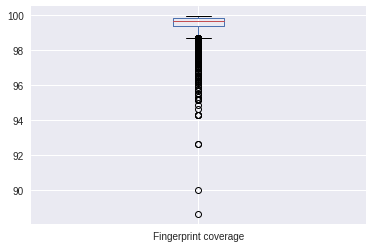

In [11]:
fingerprint_coverage.plot(kind="box")

In [12]:
fingerprint_coverage.describe()

count    4916.000000
mean       99.504838
std         0.631407
min        88.628967
25%        99.389748
50%        99.674532
75%        99.837266
max        99.938975
Name: Fingerprint coverage, dtype: float64

## Load fingerprint distances

In [13]:
fingerprint_distance_file = DATA / "fingerprint_distances_41-41-41-41-41-41-41-41-83-83-83-83-111-111-111.json"

In [14]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_json(fingerprint_distance_file)

In [15]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 293
Number of structures: 4918


In [16]:
structure_distances = fingerprint_distance_generator.data

### Remove unwanted structures

In [17]:
# Remove code after when using latest data
structure_distances = structure_distances[
        ~structure_distances.apply(
        lambda x: (x["structure1"] in [59, 7083]) or (x["structure2"] in [59, 7083]), 
        axis=1
    )
]

### Sanity check: NaN distances?

In [18]:
structure_distances[structure_distances["distance"].isna()].shape

(0, 6)

### Sort fingerprint/kinase pairs (alphabetically)

In [19]:
%time structure_distances["structure_pair"] = structure_distances[["structure1", "structure2"]].apply(list, axis=1).apply(sorted)
%time structure_distances["kinase_pair"] = structure_distances[["kinase1", "kinase2"]].apply(list, axis=1).apply(sorted)

structure_distances["structure1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 1min 16s, sys: 1.31 s, total: 1min 17s
Wall time: 1min 17s
CPU times: user 1min 8s, sys: 1.1 s, total: 1min 9s
Wall time: 1min 9s


,structure1,structure2,kinase1,kinase2,distance,coverage
0,3835,6679,AAK1,AAK1,0.053726,0.995417
1,3835,7156,AAK1,AAK1,0.066557,0.994583
2,1104,3835,AAK1,ABL1,0.251198,0.994167
3,1065,3835,AAK1,ABL1,0.264613,0.994167
4,1090,3835,AAK1,ABL1,0.233935,0.994167


## Fingerprint pair coverage

### Coverage between fingerprint pairs

In [20]:
COVERAGE_CUTOFF=0.8

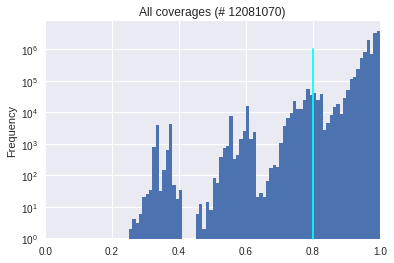

In [21]:
fig, ax = plt.subplots(1, 1)
structure_distances["coverage"].plot(
    kind="hist", title=f"All coverages (# {structure_distances.shape[0]})", bins=np.arange(0, 1.05, 0.01), xlim=(0, 1), logy=True
);
ax.plot([COVERAGE_CUTOFF, COVERAGE_CUTOFF], [0, 1000000], color="cyan")

We might want to filter out some fingerprint pairs because the coverage is super low.

In [22]:
structure_distances["coverage"].describe()

count    1.208107e+07
mean     9.706215e-01
std      4.487129e-02
min      2.500000e-01
25%      9.641667e-01
50%      9.841667e-01
75%      9.904167e-01
max      9.983333e-01
Name: coverage, dtype: float64

### Filter distances by coverage cutoff

In [23]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["coverage"].values < COVERAGE_CUTOFF, np.nan, structure_distances["distance"].values
)
structure_distances.head()

,structure1,structure2,kinase1,kinase2,distance,coverage,distance_filtered
0,3835,6679,AAK1,AAK1,0.053726,0.995417,0.053726
1,3835,7156,AAK1,AAK1,0.066557,0.994583,0.066557
2,1104,3835,AAK1,ABL1,0.251198,0.994167,0.251198
3,1065,3835,AAK1,ABL1,0.264613,0.994167,0.264613
4,1090,3835,AAK1,ABL1,0.233935,0.994167,0.233935


In [24]:
structure_distances_filtered = structure_distances[structure_distances["distance_filtered"].notna()]

In [25]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11851916


## Structure > kinase distances (minimum)

In [26]:
kinase_distances = structure_distances.groupby(["kinase1", "kinase2"]).min().reset_index()
kinase_distances.head()

,kinase1,kinase2,structure1,structure2,distance,coverage,distance_filtered
0,AAK1,AAK1,3835,6679,0.052126,0.994583,0.052126
1,AAK1,ABL1,1045,3835,0.200719,0.945000,0.200719
2,AAK1,ABL2,111,3835,0.211415,0.987917,0.211415
3,AAK1,ACK,3392,3835,0.207997,0.793333,0.207997
4,AAK1,ACTR2,2675,3835,0.227388,0.993333,0.227388


In [27]:
kinase_distances_filtered = kinase_distances[kinase_distances["distance_filtered"].notna()]

In [28]:
print(f"Kinase pairs: {kinase_distances.shape[0]}")
print(f"Kinase pairs not-NaN: {kinase_distances_filtered.shape[0]}")

Kinase pairs: 42717
Kinase pairs not-NaN: 40695


## Kinase matrix

### All distances

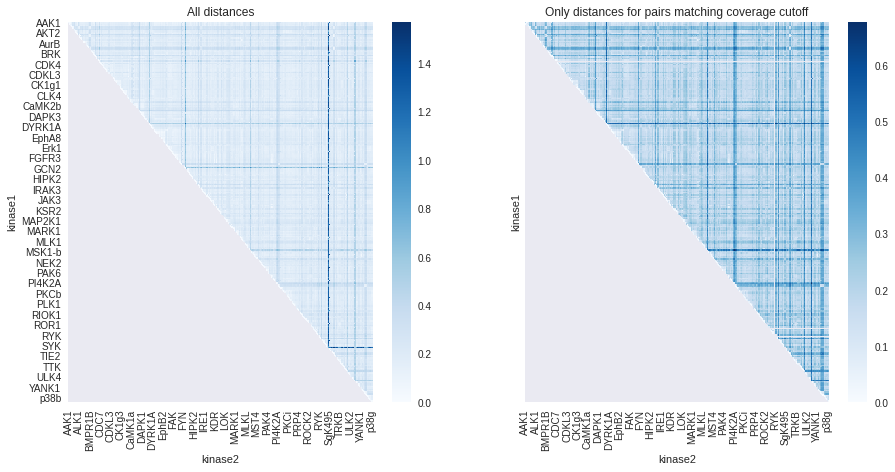

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15,7), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase1", "kinase2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase1", "kinase2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [30]:
def n_pairs(n):
    return int((n**2 - n) / 2 + n) 

In [31]:
n_structures = pd.concat([structure_distances['structure1'], structure_distances['structure2']]).unique().shape[0]
n_kinases = pd.concat([structure_distances['kinase1'], structure_distances['kinase2']]).unique().shape[0]
n_structures_filtered = pd.concat([structure_distances_filtered['structure1'], structure_distances_filtered['structure2']]).unique().shape[0]
n_kinases_filtered = pd.concat([structure_distances_filtered['kinase1'], structure_distances_filtered['kinase2']]).unique().shape[0]
 

table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0], 
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ]
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ]
)
table

,All distances,Only distances matching cutoff
Number of structures,4916,4877
Number of structure pairs (theory),12085986,11895003
Number of structure pairs (experimental),12081070,11851916
Number of kinases,292,285
Number of kinase pairs (theory),42778,40755
Number of kinase pairs (experimental),42717,40695


## Structure distances

### Structure distance distributions for different subsets

- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

In [32]:
structure_distances_intra = structure_distances[
    structure_distances["kinase1"] == structure_distances["kinase2"]
]
structure_distances_inter = structure_distances[
    ~(structure_distances["kinase1"] == structure_distances["kinase2"])
]

structure_distances_filtered_intra = structure_distances_filtered[
    structure_distances_filtered["kinase1"] == structure_distances_filtered["kinase2"]
]
structure_distances_filtered_inter = structure_distances_filtered[
    ~(structure_distances_filtered["kinase1"] == structure_distances_filtered["kinase2"])
]

#### Without coverage cutoff

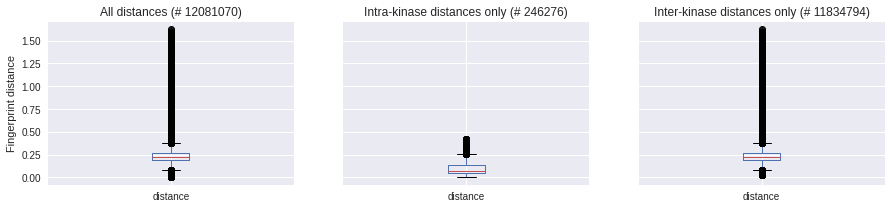

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15,3), sharey=True)
structure_distances["distance"].plot(ax=axes[0], kind="box", title=f"All distances (# {structure_distances.shape[0]})")
structure_distances_intra["distance"].plot(
    ax=axes[1], kind="box", title=f"Intra-kinase distances only (# {structure_distances_intra.shape[0]})"
)
structure_distances_inter["distance"].plot(
    ax=axes[2], kind="box", title=f"Inter-kinase distances only (# {structure_distances_inter.shape[0]})"
)
axes[0].set_ylabel("Fingerprint distance");

#### With coverage cutoff

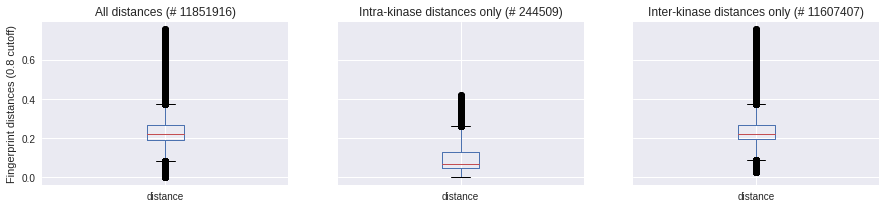

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15,3), sharey=True)
structure_distances_filtered["distance"].plot(ax=axes[0], kind="box", title=f"All distances (# {structure_distances_filtered.shape[0]})")
structure_distances_filtered_intra["distance"].plot(
    ax=axes[1], kind="box", title=f"Intra-kinase distances only (# {structure_distances_filtered_intra.shape[0]})"
)
structure_distances_filtered_inter["distance"].plot(
    ax=axes[2], kind="box", title=f"Inter-kinase distances only (# {structure_distances_filtered_inter.shape[0]})"
)
axes[0].set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)");

In [35]:
pd.DataFrame(
    {
        "Intra-kinase distances": structure_distances_filtered_intra["distance"].describe(),
        "Inter-kinase distances": structure_distances_filtered_inter["distance"].describe()
    }
)

,Intra-kinase distances,Inter-kinase distances
count,244509.000000,1.160741e+07
mean,0.089543,2.401364e-01
std,0.055991,6.867605e-02
min,0.000000,2.624518e-02
25%,0.046332,1.947127e-01
50%,0.069633,2.241750e-01
75%,0.131997,2.667881e-01
max,0.419469,7.574618e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

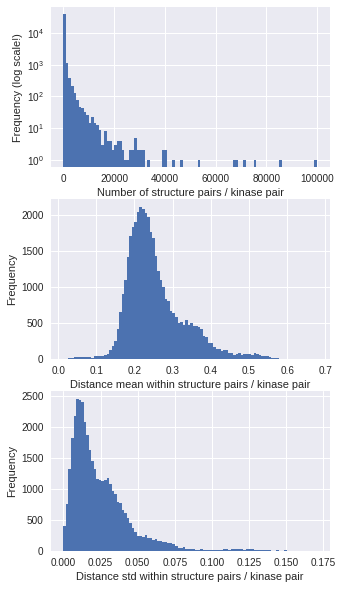

In [36]:
data = structure_distances_filtered[["kinase1", "kinase2", "distance"]].groupby(["kinase1", "kinase2"])

fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [37]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  1809
size < 5:  7312
size < 10:  12061
size < 100:  29137
size < 1000:  38505
size < 10000:  40556
size:  40695


In [38]:
data.mean().describe()

,distance
count,40695.000000
mean,0.254595
std,0.076776
min,0.013667
25%,0.203749
50%,0.236724
75%,0.288148
max,0.678254


In [39]:
data.std().describe()

,distance
count,38886.000000
mean,0.024682
std,0.020206
min,0.000004
25%,0.010802
50%,0.018944
75%,0.032899
max,0.170672


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [40]:
from itertools import combinations_with_replacement

In [41]:
KINASES_KLIFS_TO_PAPER = {
    'EGFR': 'EGFR',
    'ErbB2': 'ErbB2',
    'KDR': 'VEGFR2',
    'p110a': 'PI3K',
    'BRAF': 'BRAF',
    'CDK2': 'CDK2',
    'LCK': 'LCK',
    'MET': 'MET',
    'p38a': 'p38a',
}

In [42]:
example_kinases = list(KINASES_KLIFS_TO_PAPER.keys())
print(example_kinases)
example_kinase_pairs = [i for i in combinations_with_replacement(example_kinases, 2)]

['EGFR', 'ErbB2', 'KDR', 'p110a', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


In [43]:
example_kinase_distances = kinase_distances_filtered[
    kinase_distances_filtered.apply(lambda x: (x["kinase1"], x["kinase2"]) in example_kinase_pairs, axis=1)
]

In [44]:
example_kinase_distances.shape

(35, 7)

In [45]:
example_kinase_matrix = example_kinase_distances.pivot("kinase1", "kinase2", "distance")
example_kinase_matrix = example_kinase_matrix.loc[example_kinases, example_kinases]
example_kinase_matrix

kinase2,EGFR,ErbB2,KDR,p110a,BRAF,CDK2,LCK,MET,p38a
kinase1,,,,,,,,,
EGFR,0.007059,0.100450,0.125192,0.262499,NaN,NaN,0.112547,0.120211,0.160412
ErbB2,NaN,0.171325,0.164603,0.314532,NaN,NaN,0.177636,0.162039,0.188942
KDR,NaN,NaN,0.015914,0.271486,NaN,NaN,0.131977,0.119749,0.146547
p110a,NaN,NaN,NaN,0.012876,NaN,NaN,NaN,NaN,0.262696
BRAF,NaN,NaN,NaN,NaN,0.013685,0.131797,0.157421,0.151485,0.160090
CDK2,NaN,NaN,NaN,NaN,NaN,0.008055,0.128742,0.125390,0.120428
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.006925,0.137548,0.155337
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007856,0.162489
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [46]:
example_kinase_matrix.columns = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.columns]
example_kinase_matrix.index = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.index]
example_kinase_matrix

,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
EGFR,0.007059,0.100450,0.125192,0.262499,NaN,NaN,0.112547,0.120211,0.160412
ErbB2,NaN,0.171325,0.164603,0.314532,NaN,NaN,0.177636,0.162039,0.188942
VEGFR2,NaN,NaN,0.015914,0.271486,NaN,NaN,0.131977,0.119749,0.146547
PI3K,NaN,NaN,NaN,0.012876,NaN,NaN,NaN,NaN,0.262696
BRAF,NaN,NaN,NaN,NaN,0.013685,0.131797,0.157421,0.151485,0.160090
CDK2,NaN,NaN,NaN,NaN,NaN,0.008055,0.128742,0.125390,0.120428
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.006925,0.137548,0.155337
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007856,0.162489
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


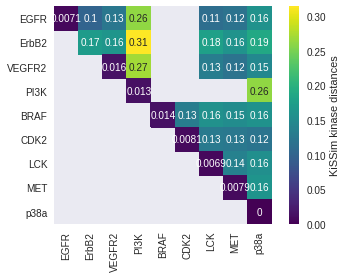

In [47]:
sns.heatmap(
    example_kinase_matrix, 
    linewidths=0, 
    annot=True, 
    square=True, cbar_kws={'label': 'KiSSim kinase distances'}, 
    cmap='viridis', 
)
plt.show()

Compare to paper (shows similarities; not distances; so think values inverse):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.